In [ ]:
# L 4-30-25

# notebooks/step_2_MFCC_RF_Classifier.ipynb

There will be some error warnings for some audio tracks that are corrupt.


C:\Users\ranuL\AppData\Local\Temp\ipykernel_8752\1911286649.py:37: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=None, duration=30)
c:\Users\ranuL\Documents\GitHub\GenreWave\venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Failed to process ../data/fma_small/098\098565.mp3: 
Failed to process ../data/fma_small/098\098567.mp3: 
Failed to process ../data/fma_small/098\098569.mp3: 
Failed to process ../data/fma_small/099\099134.mp3: 
Failed to process ../data/fma_small/108\108925.mp3: 
Failed to process ../data/fma_small/133\133297.mp3: 
               precision    recall  f1-score   support

   Electronic       0.43      0.44      0.44       200
 Experimental       0.46      0.29      0.36       200
         Folk       0.55      0.64      0.59       200
      Hip-Hop       0.47      0.58      0.52       199
 Instrumental       0.49      0.56      0.53       200
International       0.55      0.54      0.55       200
          Pop       0.28      0.21      0.24       200
         Rock       0.52      0.56      0.54       200

     accuracy                           0.48      1599
    macro avg       0.47      0.48      0.47      1599
 weighted avg       0.47      0.48      0.47      1599



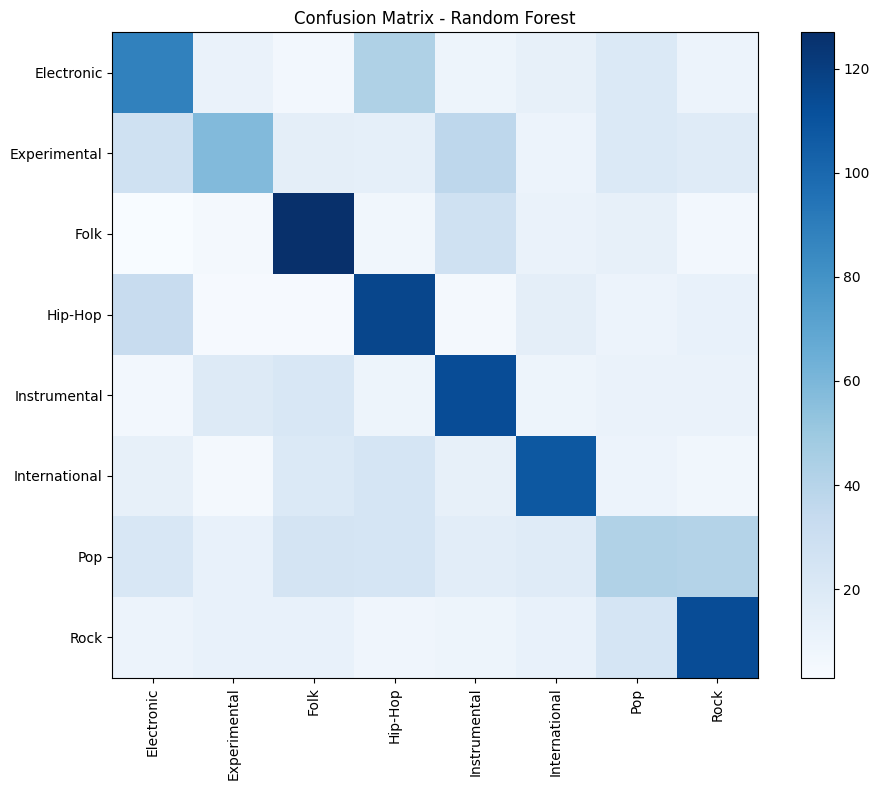

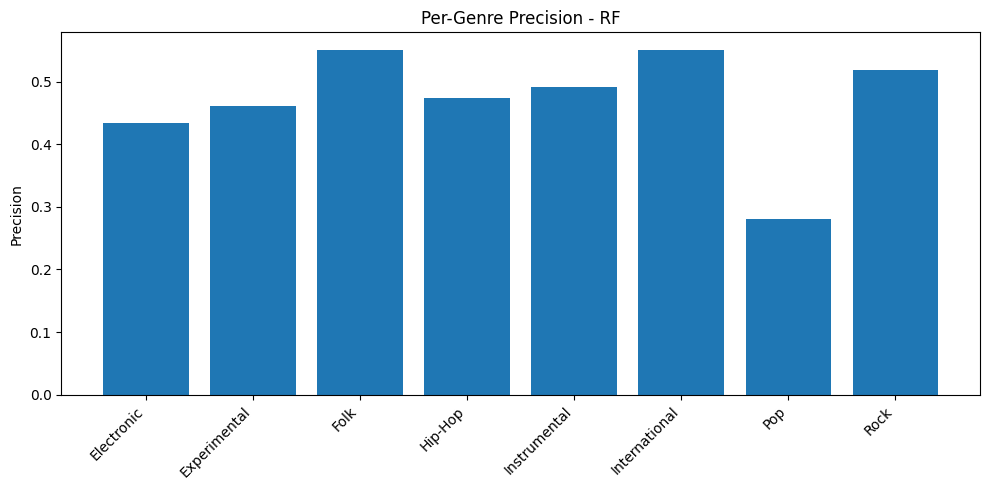

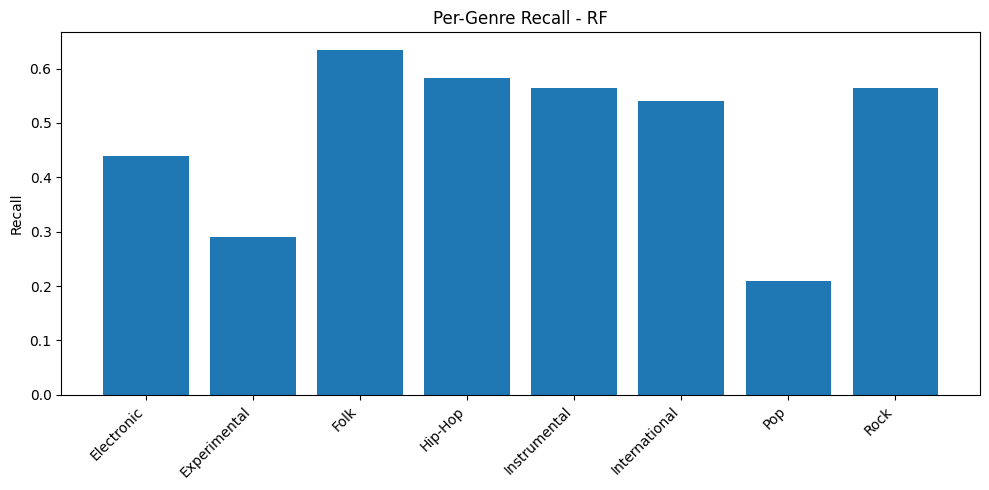

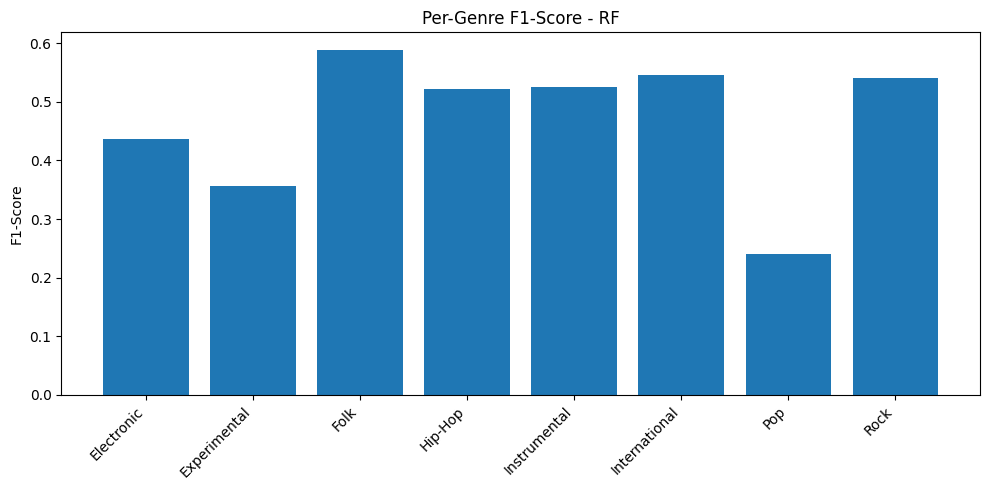

In [2]:
# notebooks/step_2_MFCC_RF.ipynb

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from collections import Counter
import joblib


# Paths
METADATA_PATH = "../reports/step_1_Explore_Metadata/valid_track_genres.csv"
AUDIO_DIR = "../data/fma_small/"
FEATURE_SAVE_PATH = "../features/mfcc_features.npz"
MODEL_SAVE_PATH = "../models/rf_model.pkl"
TEST_OUTPUTS_PATH = "../features/rf_test_outputs.npz"
REPORT_DIR = "../reports/step_2_MFCC_RF/"
SONG_INFERENCE_DIR = "../data/Songs/"
INFERENCE_OUTPUT_DIR = "../reports/step_final_classify/"



SHOW_PLOTS = False # This is so plots show on notebook but not when called from classify

# Load track genre metadata
def load_metadata(path):
    df = pd.read_csv(path)
    return df.dropna(subset=['genre_top'])

# Extract MFCCs from a single audio file
def extract_mfcc(path, n_mfcc=20):
    try:
        y, sr = librosa.load(path, sr=None, duration=30)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfcc, axis=1), np.std(mfcc, axis=1)
    except Exception as e:
        print(f"Failed to process {path}: {e}")
        return None, None

# Train RF model and return it
def train_rf_model(X, y):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    return clf

# Save evaluation results
def evaluate_rf_model(clf, X_test, y_test, class_labels, report_dir):
    y_pred = clf.predict(X_test)
    os.makedirs(report_dir, exist_ok=True)

    report = classification_report(y_test, y_pred, labels=class_labels, zero_division=0)
    with open(os.path.join(report_dir, "rf_classification_report.txt"), "w") as f:
        f.write(report)
    print(report)

    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title("Confusion Matrix - Random Forest")
    plt.colorbar()
    plt.xticks(np.arange(len(class_labels)), class_labels, rotation=90)
    plt.yticks(np.arange(len(class_labels)), class_labels)
    plt.tight_layout()
    plt.savefig(os.path.join(report_dir, "rf_confusion_matrix.png"))
    if SHOW_PLOTS:
        plt.show()
    plt.close()

    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, labels=class_labels, zero_division=0)

    metrics = {"Precision": precision, "Recall": recall, "F1-Score": f1}
    for metric, values in metrics.items():
        plt.figure(figsize=(10, 5))
        plt.bar(class_labels, values)
        plt.ylabel(metric)
        plt.title(f"Per-Genre {metric} - RF")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        filename = f"rf_per_genre_{metric.lower().replace('-', '_')}.png"
        plt.savefig(os.path.join(report_dir, filename))
        if SHOW_PLOTS:
            plt.show()
        plt.close()

# Training pipeline
def process_training_data():
    os.makedirs(REPORT_DIR, exist_ok=True)
    df = load_metadata(METADATA_PATH)
    track_ids = df['track_id'].astype(str).str.zfill(6)
    labels = df['genre_top'].tolist()
    subgenres_list = df['subgenres'].apply(eval).tolist()

    X, y, used_info, failed_info = [], [], [], []

    for idx, track_id in enumerate(track_ids):
        path = os.path.join(AUDIO_DIR, track_id[:3], f"{track_id}.mp3")
        genre = labels[idx]
        subgenres = subgenres_list[idx]

        if not os.path.isfile(path):
            failed_info.append({"track_id": track_id, "reason": "file not found", "genre": genre, "subgenres": subgenres})
            continue

        mfcc_mean, mfcc_std = extract_mfcc(path)
        if mfcc_mean is not None:
            X.append(np.concatenate([mfcc_mean, mfcc_std]))
            y.append(genre)
            used_info.append({"track_id": track_id, "genre": genre, "subgenres": subgenres})
        else:
            failed_info.append({"track_id": track_id, "reason": "processing error", "genre": genre, "subgenres": subgenres})

    X = np.array(X)
    y = np.array(y)
    np.savez(FEATURE_SAVE_PATH, X=X, y=y)

    pd.DataFrame(used_info).to_csv(os.path.join(REPORT_DIR, "used_tracks.csv"), index=False)
    pd.DataFrame(failed_info).to_csv(os.path.join(REPORT_DIR, "failed_tracks.csv"), index=False)

    genre_counts = Counter([row['genre'] for row in used_info])
    subgenre_counts = Counter([sub for row in used_info for sub in row['subgenres']])
    g_df = pd.DataFrame(list(genre_counts.items()), columns=["label", "count"])
    g_df["type"] = "genre"
    s_df = pd.DataFrame(list(subgenre_counts.items()), columns=["label", "count"])
    s_df["type"] = "subgenre"
    pd.concat([g_df, s_df]).to_csv(os.path.join(REPORT_DIR, "genre_subgenre_counts.csv"), index=False)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    clf = train_rf_model(X_train, y_train)
    joblib.dump(clf, MODEL_SAVE_PATH)
    np.savez(TEST_OUTPUTS_PATH, X_test=X_test, y_test=y_test, y_pred=clf.predict(X_test))
    evaluate_rf_model(clf, X_test, y_test, sorted(set(y)), REPORT_DIR)

# Inference for classify_new_song
def run_rf_inference_on_folder(song_folder, model_path=MODEL_SAVE_PATH, output_dir=INFERENCE_OUTPUT_DIR):
    clf = joblib.load(model_path)
    results = []

    for root, _, files in os.walk(song_folder):
        true_genre = os.path.basename(root)
        for file in files:
            if not file.endswith(".mp3"):
                continue
            full_path = os.path.join(root, file)
            mfcc_mean, mfcc_std = extract_mfcc(full_path)
            if mfcc_mean is None:
                continue
            vec = np.concatenate([mfcc_mean, mfcc_std]).reshape(1, -1)
            prediction = clf.predict(vec)[0]
            results.append((file, true_genre, prediction))

    df = pd.DataFrame(results, columns=["file", "true_genre", "predicted_genre"])
    os.makedirs(output_dir, exist_ok=True)
    df.to_csv(os.path.join(output_dir, "rf_predictions.csv"), index=False)
    print("Saved RF predictions to", output_dir)
    return df

# Entrypoint
if __name__ == "__main__":
    SHOW_PLOTS = True
    print("There will be some error warnings for some audio tracks that are corrupt.")
    process_training_data()